In [33]:
%matplotlib inline
try:
    import cPickle as pickle
except:
    import pickle
import multiprocessing
import json
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import pywt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from collections import Counter
from sklearn.decomposition import PCA
import random

In [34]:
def SaveDataFrame(df,picklefile):
    pickle.dump(df,open(picklefile,'w+'))
def LoadDataFrame(picklefile):
    superdf = pickle.load(open(picklefile))
    return superdf
def ObtainSessionData(df,user,session,date):
    return df[df.apply(lambda x:x['User'] == user and x['Session'] == session and x['Day'] == date,axis=1)]

In [35]:
def distance_on_unit_sphere(lat1, long1, lat2=48.787980, long2=11.381053):
        # Convert latitude and longitude to 
        # spherical coordinates in radians.
        #if np.isnan(lat1) or np.isnan(long1) or np.isnan(lat2) or np.isnan(long2):
        #   return 10**6
        degrees_to_radians = math.pi/180.0
        # phi = 90 - latitude
        phi1 = lat1*degrees_to_radians
        phi2 = lat2*degrees_to_radians
        # theta = longitude
        theta1 = long1*degrees_to_radians
        theta2 = long2*degrees_to_radians
        # Compute spherical distance from spherical coordinates.
        cos = math.sin(phi1)*math.sin(phi2) + math.cos(phi1)*math.cos(phi2)*math.cos(theta2-theta1)
        if abs(cos) < 1:
                arc = math.acos( cos )
        else:
                arc = 0
        return arc*3960 #Miles
def CreateDataFrameWrapper(info_tuple):
    return CreateDataFrame(lat=info_tuple[0],long=info_tuple[1],heading_start=info_tuple[2],heading_end=info_tuple[3])

def CreateDataFrame(lat=48.787980,long=11.381053,radius=100,heading_start=270.0,heading_end=360.0,heading_tol=20):
        global users
        global userid
        radius = (radius+2.5)/5280.0
        dataframes = []
        #heading_start,heading_end = min(heading_start,heading_end),max(heading_start,heading_end)
        for user in users:
                simpleId = userid[user]
                allDates = users[user]
                usertimeinfo = {}
                userfeatures = {}
                for date in allDates:
                        userDir = '/dfs/scratch0/abhisg/granular_analysis/new_data/'+simpleId+'/'+date+'/'
                        files = sorted(os.listdir(userDir))
                        session = 0
                        for file in files:
                                if os.stat(userDir+file).st_size > 0:
                                        #print userDir+file
                                        df = pd.read_csv(userDir+file,delim_whitespace=True,header=None).dropna()
                                        if df.shape[0] == 0: #highly unlikely but a failsafe check
                                            continue
                                        df.columns = ["Day", "Time", "Steer_Angle", "Velocity", "Heading", "Latitude", "Longitude", "Brightness", "Road_Type", \
                                                "Num_Oncoming_Lanes", "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal", "Fuel", "X_Accel", \
                                                "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request", "L_Sig", "R_Sig"]
                                        df['Distance'] = df.apply(lambda x:distance_on_unit_sphere(x['Latitude'],x['Longitude'],lat,long),axis=1)
                                        #modular arithmetic crap. Need to distinguish SE,NW,WN and ES turns from the directions flipped
                                        df = df[df.apply(lambda x:x['Distance'] <= radius,axis=1)]
                                        if df.shape[0] == 0:
                                            print "No data found for", user,date,file
                                            continue
                                        listOfIndices = df.index
                                        startindex,endindex = 0,1
                                        while endindex < len(listOfIndices):
                                            if listOfIndices[endindex] - listOfIndices[endindex-1] > 100: #discontinuity;session jump
                                                startHeading,endHeading = df['Heading'].iloc[startindex],df['Heading'].iloc[endindex-1]
                                                #print startHeading,endHeading
                                                if ((startHeading >= heading_start - heading_tol and startHeading <= heading_start + heading_tol) or\
                                                    startHeading >= heading_start + 360 - heading_tol or startHeading <= heading_start - 360 + heading_tol) and\
                                                    ((endHeading >= heading_end - heading_tol and endHeading <= heading_end + heading_tol) or\
                                                    startHeading >= heading_end + 360 - heading_tol or endHeading <= heading_end - 360 + heading_tol):
                                                        df_subset = df[np.logical_and(df.index >= listOfIndices[startindex],df.index < listOfIndices[endindex])]
                                                        print simpleId,date,session,startHeading,endHeading,listOfIndices[startindex],listOfIndices[endindex-1],df_subset.shape,df_subset['Latitude'].iloc[0],df_subset['Longitude'].iloc[0],df_subset['Latitude'].iloc[df_subset.shape[0]-1],df_subset['Longitude'].iloc[df_subset.shape[0]-1]
                                                        df_subset['User'] = pd.Series(np.repeat(simpleId,df_subset.shape[0]),index=df_subset.index)
                                                        df_subset['Session'] = pd.Series(np.repeat(session,df_subset.shape[0]),index=df_subset.index)
                                                        dataframes.append(df_subset)
                                                        startindex = endindex
                                                        session = session + 1
                                            endindex = endindex + 1
                                        startHeading,endHeading = df['Heading'].iloc[startindex],df['Heading'].iloc[endindex-1]
                                        if ((startHeading >= heading_start - heading_tol and startHeading <= heading_start + heading_tol) or\
                                            startHeading >= heading_start + 360 - heading_tol or startHeading <= heading_start - 360 + heading_tol) and\
                                            ((endHeading >= heading_end - heading_end and endHeading <= heading_end + heading_tol) or\
                                            startHeading >= heading_end + 360 - heading_tol or endHeading <= heading_end - 360 + heading_tol):
                                                df_subset = df[np.logical_and(df.index >= listOfIndices[startindex],df.index <= listOfIndices[endindex-1])]
                                                print simpleId,date,session,startHeading,endHeading,listOfIndices[startindex],listOfIndices[endindex-1],df_subset.shape,df_subset['Latitude'].iloc[0],df_subset['Longitude'].iloc[0],df_subset['Latitude'].iloc[df_subset.shape[0]-1],df_subset['Longitude'].iloc[df_subset.shape[0]-1]
                                                df_subset['User'] = pd.Series(np.repeat(simpleId,df_subset.shape[0]),index=df_subset.index)
                                                df_subset['Session'] = pd.Series(np.repeat(session,df_subset.shape[0]),index=df_subset.index)
                                                dataframes.append(df_subset)
                                                startindex = endindex
                                                session = session + 1
                                        else:
                                            print "No match found : Start heading",startHeading,"End heading",endHeading

        if len(dataframes) > 0:
            return pd.concat(dataframes,axis=0)
        else:
            return []

In [36]:
def CreateAlignment(superdf,userid=None,sessionid=None,scheme=1):
        if scheme == 1:
                return AlignmentByLatLong(superdf,userid,sessionid)
            
def AlignmentByLatLong(superdf,userid=None,sessionid=None,date=None):
        random.seed(1)
        signature = superdf[['User','Session','Day']].drop_duplicates()
        if userid is None or userid not in signature['User'] or sessionid is None or sessionid not in signature['Session'] or date is None or date not in signature['Day']:
                duplicates = superdf.groupby(['User','Day','Session']).size()
                duplicates_dataframe = duplicates.reset_index()
                counts = sorted([(i,duplicates.iloc[i]) for i in xrange(len(duplicates))],key=lambda x:x[1])
                randombottomindex = random.choice(counts[int(0.2*len(counts)):int(0.3*len(counts))])[0]
                trials = 0
                while trials < 100 and duplicates.iloc[randombottomindex] < 100: #choose parameters intelligently
                    randombottomindex = random.choice(counts[int(0.2*len(counts)):int(0.3*len(counts))])[0]
                    trials = trials + 1
                #print "Picked index",randombottomindex,"with state size",duplicates.iloc[randombottomindex]
                userid,sessionid,date = duplicates_dataframe['User'].iloc[randombottomindex],duplicates_dataframe['Session'].iloc[randombottomindex],\
                duplicates_dataframe['Day'].iloc[randombottomindex]
                print "Picked user",userid,"session",sessionid,"date",date,"with state size",duplicates.iloc[randombottomindex]
        #define the benchmark lat long values and the corresponding distance matrix
        gdist = []
        df = superdf[superdf.apply(lambda x:x['User'] == userid and x['Session'] == sessionid and date == x['Day'],axis=1)]
        gdist,lat,long = -df['Distance'].values,df['Latitude'].values,df['Longitude'].values
        for i in xrange(1,gdist.shape[0]):
                gdist[i] = gdist[i-1] + distance_on_unit_sphere(lat[i],long[i],lat[i-1],long[i-1])
        dataframes = []
        #loop over all unique sessions and add the aligned dataframe to the list of dataframes
        for idx in xrange(signature.shape[0]):
            user,session,day = signature['User'].iloc[idx],signature['Session'].iloc[idx],signature['Day'].iloc[idx]
            df = superdf[superdf.apply(lambda x:x['User'] == user and x['Session'] == session and day == x['Day'],axis=1)]
            if df.shape[0] == 0:
                continue
            baseline = df.index[0]
            if user != userid or session != sessionid or day != date:
                    retain = []
                    i,targetidx = 1,0
                    dist,lat,long = -df['Distance'].values,df['Latitude'].values,df['Longitude'].values
                    while i < len(lat) and dist[i-1] < gdist[targetidx]:
                        i = i + 1
                    if i > 1:
                        i = i - 1
                    if i < len(lat):
                        retain.append(baseline+i-1)
                        distance,targetidx = dist[i-1],targetidx+1
                    else:
                        continue
                    #print i,dist[i-1],gdist[targetidx-1]
                    while i < len(lat)-1 and targetidx < gdist.shape[0]:        
                        curdist = distance + distance_on_unit_sphere(lat[i],long[i],lat[i-1],long[i-1])
                        nextdist = curdist + distance_on_unit_sphere(lat[i+1],long[i+1],lat[i],long[i])
                        if curdist == gdist[targetidx] or (curdist < gdist[targetidx] and nextdist > gdist[targetidx]):
                            retain.append(baseline+i)
                            targetidx,distance,i = targetidx + 1,curdist,i+1
                        elif curdist > gdist[targetidx] :
                            retain.append(baseline+max(i-1,0))
                            targetidx = targetidx + 1
                        else:
                            distance,i = curdist,i+1
                    #fill in the remaining values with the last recorded instance
                    while targetidx < gdist.shape[0]:
                        retain.append(baseline+len(lat)-1)
                        targetidx = targetidx + 1
                    #keep only the indices which correspond to the alignment
                    df = df.loc[np.array(retain)]
            if df.shape[0] > 0:
                df['State'] = pd.Series(np.arange(df.shape[0]),index=df.index)
                print idx,user,session,day,df['Time'].iloc[0],df['Time'].iloc[-1]
                dataframes.append(df)
            else:
                continue
        return pd.concat(dataframes,axis=0)

In [59]:
def FeaturesForClassifier(superdf,featurecolumns,simplestatistics=True,complexstatistics=True,rawfeatures=False,users=None):
    signature = superdf[['User','Session','Day']].drop_duplicates()
    #print signature.loc[signature['User'].isin(users)]
    if users is not None:
        signature = signature.loc[signature['User'].isin(users)]
    states = superdf['State'].drop_duplicates()
    features,labels,labelcount = [],[],0
    if complexstatistics == True:
        appxfeatures = [[] for col in featurecolumns]
        detailfeatures = [[] for col in featurecolumns]
    if rawfeatures == True:
        rfeatures = [[] for col in featurecolumns]
    #print signature.shape[0]
    for i in xrange(signature.shape[0]):
        df = ObtainSessionData(superdf,signature['User'].iloc[i],signature['Session'].iloc[i],signature['Day'].iloc[i])
        if df.shape[0] == 0: #wrong values have crept in. Debug
            continue
        #simple features are yanked from the time series 'as is'. Complex features are obtained from DWT of the time series
        currentsimplefeatures = []
        serieslists = []
        for j,col in enumerate(featurecolumns):
            if df[col].dtype != object:
                series = df[col].values
            else:
                series = np.array([0 if val == 'f' else 1 for val in df[col].values])
            serieslists.append(series)
            if rawfeatures == True:
                rfeatures[j].append(series)
            else:
                if simplestatistics == True:
                    currentsimplefeatures = currentsimplefeatures +  [np.mean(series),np.std(series),scipy.stats.skew(series),\
                                                  scipy.stats.kurtosis(series),np.max(series)\
                                                ,np.min(series),scipy.signal.correlate(series,series)[0]]
                if complexstatistics == True:
                    appx,detail = pywt.dwt(series,'haar')
                    appxfeatures[j].append(appx)
                    detailfeatures[j].append(detail)
        #if simplestatistics == True:
        #    for j in xrange(len(serieslists)):
        #        for k in xrange(j+1,len(serieslists)):
        #            currentsimplefeatures = currentsimplefeatures + [scipy.signal.correlate(serieslists[j],serieslists[k])[0]]
        print signature['User'].iloc[i],signature['Session'].iloc[i],signature['Day'].iloc[i]
        features.append(currentsimplefeatures)
        labels.append(int(signature['User'].iloc[i]))
    if complexstatistics == True and rawfeatures == False:
        pca_model = PCA(n_components = min(10,len(appxfeatures[j])))
        for j in xrange(len(featurecolumns)):
            #minlen1,minlen2 = min([len(elem) for elem in appxfeatures[j]]),min([len(elem) for elem in detailfeatures[j]])
            #for k in xrange(len(appxfeatures[j])):
            #    appxfeatures[j][k] = appxfeatures[j][k][:minlen1]
            #for k in xrange(len(detailfeatures[j])):
            #    detailfeatures[j][k] = detailfeatures[j][k][:minlen2]
            #appxfeatures[j] = pca_model.fit_transform(appxfeatures[j])
            #detailfeatures[j] = pca_model.fit_transform(detailfeatures[j])
            for k in xrange(len(features)):
                features[k] = features[k] + appxfeatures[j][k].tolist() + detailfeatures[j][k].tolist()
    elif rawfeatures == True:
        pca_model = PCA(n_components=5)
        for j in xrange(len(featurecolumns)):
            rfeatures[j] = pca_model.fit_transform(rfeatures[j])
            for k in xrange(len(features)):
                features[k] = features[k] + rfeatures[j][k].tolist()
                #print k,len(features[k])
    #features = np.array(features)
    print len(features)
    return np.column_stack((features,labels))

def ClassificationPipeline(superdf=None,featurecolumns=None,loadfile=False,savefile=True,simplestatistics=True,complexstatistics=True,classifier='RandomForest',filename=None,users=None):
    if loadfile == True:
        if filename is None:
            print "Must specify pickle file containing the data"
            return
        data = pickle.load(open(filename))
    else:
        if simplestatistics == False and complexstatistics == False:
            print "No statistics have been specified!"
            return
        if superdf is None:
            print "Cannot proceed without a dataframe to work on !"
            return
        if featurecolumns is None:
            featurecolumns = ["Steer_Angle", "Velocity", "Heading", "Brightness", "Road_Type", "Num_Oncoming_Lanes", \
                              "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal",\
                              "Fuel", "X_Accel", "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request"]
        data = FeaturesForClassifier(superdf,featurecolumns,simplestatistics,complexstatistics,users)
        if savefile == True:
            if filename is not None:
                pickle.dump(data,open(filename,'w+'))
                print "Data saved for future reference"
            else:
                print "Cannot save data since filename has not been specified"
    features,labels = data[:,:-1],data[:,-1]
    #print features.shape
    if users is None:
        users = map(int,np.unique(labels))
    else:
        users = map(int,users)
    print users
    idx = []
    for i in xrange(len(labels)):
        if labels[i] in users:
            idx.append(i)
    idx = np.array(idx)
    data_X,data_Y = features[idx,:],labels[idx]
    #cvobj = StratifiedKFold(data_Y,n_folds=10)
    cvobj = StratifiedShuffleSplit(data_Y,n_iter=100,random_state=1,test_size=len(users))
    actual,predictions=[],[]
    percentage = [{user:0 for user in users} for idx in xrange(len(data_Y))]
    #importance = np.zeros((data_X.shape[1]/37,1))
    for train_idx,test_idx in cvobj:
        if classifier == 'RandomForest':
            counts = Counter(data_Y[train_idx])
            sample_weight = [1-counts[data_Y[idx]]*1./len(train_idx) for idx in train_idx]
            model = RandomForestClassifier(n_estimators=1000,class_weight='subsample',\
                                           criterion='entropy',max_features='auto',\
                                           random_state=1,n_jobs=-1)
            model.fit(data_X[train_idx,:],data_Y[train_idx],sample_weight=None)
            #importances = sorted([(i,model.feature_importances_[i]) for i in xrange(len(model.feature_importances_))],key = lambda x:x[1],reverse=True)[0:50]
            #for i in xrange(len(importances)):te
            #    idx = importances[i][0]/37    #parameterise this stuff
            #    importance[idx] = importance[idx] + 1.0/(i+1)
        elif classifier == "MultinomialRegression":
            model = LogisticRegression(class_weight='auto')
            model.fit(data_X[train_idx,:],data_Y[train_idx])
        else:
            model = SVC(kernel='linear')
            model.fit(data_X[train_idx,:],data_Y[train_idx])
        actual = actual + data_Y[test_idx].tolist()
        predictions = predictions + model.predict(data_X[test_idx,:]).tolist()
        newpreds = model.predict(data_X[test_idx,:])
        for i in xrange(len(test_idx)):
            percentage[test_idx[i]][newpreds[i]] = percentage[test_idx[i]][newpreds[i]] + 1
        print confusion_matrix(actual,predictions,users)
    for i in xrange(len(data_Y)):
        print data_Y[i],percentage[i]
    #print importance
    #plt.bar(list(xrange(importance.shape[0])),importance)
    #plt.show()
    print confusion_matrix(actual,predictions,users)
    plt.imshow(confusion_matrix(actual,predictions,users), interpolation='nearest')
    plt.show()        
    
def ClusteringPipeline(data_X,data_Y,users,n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    data_X = (data_X-numpy.min(data_X,axis=0))/(numpy.max(data_X,axis=0)-numpy.min(data_X,axis=0))
    kmeans.fit(data_X)
    classfrequency = [[0 for label in users] for i in xrange(n_clusters)]
    for i in xrange(data_X.shape[0]):
        label = int(data_Y[i])
        if label in users:
            predictedcluster,label = kmeans.predict(data_X[i])[0],int(data_Y[i])
            classfrequency[predictedcluster][users.index(label)] = classfrequency[predictedcluster][users.index(label)] + 1
    classfrequency = np.array(classfrequency,dtype=float)
    #print classfrequency
    classfrequency /= 1.0*sum(classfrequency)
    #print classfrequency
    colors = ['b','g','r','c','m','y','k']
    width = 0.75/len(users)
    axis = np.array(xrange(classfrequency.shape[0]))
    for i in xrange(classfrequency.shape[1]):
        plt.bar((width)*i+axis,classfrequency[:,i],color=colors[(i+1)%len(colors)],width=width)
    plt.xlabel("Clusters")
    plt.ylabel("User Fraction")
    plt.show()
    
    #distribution = []
    #for label in users:
    #    distribution.append(max(classfrequency[users.index(label)][0],classfrequency[users.index(label)][1])*1.0/sum(classfrequency[users.index(label)]))
    #width = 1./n_clusters
    
    #plt.bar(users,distribution)
    #plt.xlabel('Label')
    #plt.ylabel('Distribution')
    #plt.show()
        
        
    

In [56]:
def plotUser(superdf,user,feature,sessions=None,days=None):
    df = superdf[superdf.apply(lambda x:x['User'] == user,axis=1)]
    if df.shape[0] == 0:
        print "No such user exists in the database"
        return
    #sessiondaytuple = df[['Session','Day']].drop_duplicates()
    sessionlist,daylist = df['Session'].drop_duplicates(),df['Day'].drop_duplicates()
    if sessions is not None:
        sessionlist = sessions
    if days is not None:
        daylist = days
    for session in sessionlist:
        for day in daylist:
            currentdf = df[df.apply(lambda x:x['Day'] == day and x['Session'] == session,axis=1)]
            #print currentdf
            if currentdf.shape[0] > 0:
                if currentdf[feature].dtype != object:
                    plt.plot(currentdf[feature])
                else:
                    plt.plot([0 if val=='f' else 1 for val in currentdf[feature]])
            else:
                print day,session,"This day,session combination does not exist"
    plt.ylabel(feature)
    plt.xlabel('Ground Truth Points')
    plt.show()
    
def plotComparison(superdf,feature,users,sessioninfo):
    colors = ['b','g','r','c','m','y','k']
    for i in xrange(len(users)):
        for session,day in sessioninfo[i]:
            df = superdf[superdf.apply(lambda x:x['User'] == users[i] and x['Day'] == day and x['Session'] == session,axis=1)]
            if df.shape[0] > 0:
                plt.plot(df[feature],colors[i%(len(colors))])
    plt.xlabel('Ground Truth Points')
    plt.ylabel(feature)
    #plt.legend(users)
    plt.show()
    
    
def plotSession(superdf,user,day,session,featurelist=None):
    df = ObtainSessionData(superdf,user,session,day)
    if df.shape[0] == 0:
        print "Could not search for this information in the database"
        return
    features = ["Steer_Angle", "Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel"]
    if featurelist is not None:
        features = featurelist
    df[features].plot()
    plt.show()

def plotFeature(superdf,feature,users=None,errorbar=False,statistic='mean'):
    userlist = superdf['User'].drop_duplicates()
    states = superdf['State'].drop_duplicates()
    if users is not None:
        userlist = users
    for user in userlist:
        df = superdf[superdf.apply(lambda x:x['User']==user,axis=1)]
        stat,error = [],[]
        for state in states:
            series = df[df.apply(lambda x:x['State']==state,axis=1)]
            if series[feature].dtype != object:
                newseries = series[feature].values
            else:
                newseries = np.array([0 if val == 'f' else 1 for val in series[feature].values])
            if statistic == 'mean':
                stat.append(np.mean(newseries))
            else:
                stat.append(np.median(newseries))
            error.append(np.std(newseries))
        print user,"done"
        if errorbar == True:
            plt.errorbar(states,stat,yerr=error)
        else:
            plt.plot(states,stat)
    plt.show()        
    

In [57]:
users = json.load(open('/dfs/scratch0/abhisg/granular_analysis/sessionsinfo.json'))
userid = {}
with open('/dfs/scratch0/abhisg/granular_analysis/user_id') as fp:
        for line in fp:
                line = line.strip().split()
                userid[line[0]] = line[1]

In [24]:
turns = ['frame_48.7751719849_11.4096909879_338.271903323_249.725075529.pkl',
        'frame_48.7749571994_11.4171988121_181.069364162_89.4190751445.pkl',
        'frame_48.7902749773_11.3816505382_25.1331444759_110.492917847.pkl',
        'frame_48.7903583135_11.3814125959_288.018134715_197.365284974.pkl',
        'frame_48.7880566803_11.3811085721_273.038461538_355.841346154.pkl',
        'frame_48.7366648289_11.4557780456_303.505703422_24.3346007605.pkl',
        'frame_48.7880144539_11.3811151809_178.508532423_91.2866894198.pkl',
        'frame_48.7743670484_11.4588970912_180.310541311_95.6495726496.pkl']
turns = ['frame_48.7746277879_11.6301796017_269.614718615_169.060606061.pkl',
        'frame_48.6277094167_11.586373679_188.828947368_281.530701754.pkl',
        'frame_48.8179459032_11.7007614931_266.714285714_173.207373272.pkl',
        'frame_48.7851406524_11.3903540143_235.352380952_323.757142857.pkl']
#pool = multiprocessing.Pool(processes=8)
superdf_list = []
for turn in turns:
    superdf_list.append(LoadDataFrame('../'+turn))
for i in xrange(len(superdf_list)):
    df = CreateAlignment(superdf_list[i])
    SaveDataFrame(df,'../processed_'+turns[i])

Picked user 7 session 0 date 2014-04-09 with state size 70
0 0 0 2014-05-09 07:42:02.800000 07:42:12.200000
1 0 1 2014-05-09 08:26:30.800000 08:26:37.900000
2 0 2 2014-05-09 09:07:46.200000 09:08:00.700000
3 0 3 2014-05-09 09:52:27.900000 09:52:34.400000
4 0 4 2014-05-09 11:03:20.000000 11:03:27.100000
5 0 5 2014-05-09 11:43:03.900000 11:43:10.800000
6 1 0 2014-04-07 09:04:26.100000 09:04:34.200000
7 1 1 2014-04-07 10:47:39.400000 10:47:49.400000
8 1 2 2014-04-07 12:39:13.500000 12:39:23.400000
9 1 0 2014-04-10 07:49:04.300000 07:49:13.200000
10 1 1 2014-04-10 08:34:18.200000 08:34:25.600000
11 1 2 2014-04-10 09:23:48.800000 09:23:56.600000
12 1 3 2014-04-10 10:31:41.800000 10:31:50.200000
13 6 0 2014-04-08 07:28:08.500000 07:28:14.900000
14 6 1 2014-04-08 08:15:46.000000 08:15:54.800000
15 6 2 2014-04-08 09:16:43.300000 09:16:50.200000
16 6 3 2014-04-08 09:57:27.000000 09:57:33.000000
17 7 0 2014-04-09 08:09:00.300000 08:09:07.200000
18 7 1 2014-04-09 08:45:57.100000 08:46:04.500000
1

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[10, 12, 35, 45]
[[0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]]
[[0 2 0 0]
 [0 2 0 0]
 [0 0 0 2]
 [1 1 0 0]]
[[0 2 0 1]
 [0 2 1 0]
 [0 0 1 2]
 [1 1 0 1]]
[[1 2 0 1]
 [0 3 1 0]
 [0 1 1 2]
 [2 1 0 1]]
[[2 2 0 1]
 [0 4 1 0]
 [1 1 1 2]
 [2 1 1 1]]
[[3 2 0 1]
 [1 4 1 0]
 [1 1 2 2]
 [2 2 1 1]]
[[3 2 1 1]
 [1 5 1 0]
 [1 2 2 2]
 [2 2 1 2]]
[[4 2 1 1]
 [1 6 1 0]
 [1 3 2 2]
 [3 2 1 2]]
[[5 2 1 1]
 [1 6 1 1]
 [1 3 3 2]
 [3 2 1 3]]
[[6 2 1 1]
 [1 7 1 1]
 [1 3 4 2]
 [3 2 2 3]]
[[6 3 1 1]
 [1 8 1 1]
 [1 3 5 2]
 [3 2 3 3]]
[[6 3 2 1]
 [1 9 1 1]
 [2 3 5 2]
 [3 2 3 4]]
[[6 3 3 1]
 [1 9 1 2]
 [2 3 5 3]
 [3 2 3 5]]
[[7 3 3 1]
 [1 9 2 2]
 [2 3 6 3]
 [3 2 3 6]]
[[7 4 3 1]
 [1 9 3 2]
 [2 3 7 3]
 [3 2 4 6]]
[[7 4 4 1]
 [2 9 3 2]
 [2 3 8 3]
 [3 2 4 7]]
[[ 7  5  4  1]
 [ 2 10  3  2]
 [ 2  3  9  3]
 [ 3  2  5  7]]
[[ 8  5  4  1]
 [ 2 11  3  2]
 [ 3  3  9  3]
 [ 3  2  5  8]]
[[ 9  5  4  1]
 [ 2 11  4  2]
 [ 3  4  9  3]
 [ 4  2  5  8]]
[[10  5  4  1]
 [ 3 11  4  2]
 [ 4  4  9  3]
 [ 4  2  5  9]]
[[11  5  4  1]
 [ 3

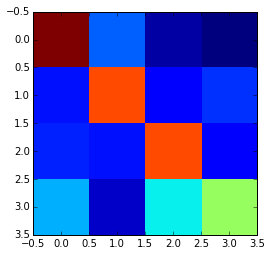

In [60]:
#longer_dataframe = CreateDataFrame(lat=48.7880566803,long=11.3811085721,radius=400,heading_start=273.038461538,heading_end=355.841346154,heading_tol=20)
#SaveDataFrame(longer_dataframe,'../longer_frame_'+str(48.7880566803)+'_'+str(11.3811085721)+'_'+str(273.038461538)+'_'+str(355.841346154))
#longer_dataframe = LoadDataFrame('../longer_frame_48.7880566803_11.3811085721_273.038461538_355.841346154')
#new_longer_dataframe = CreateAlignment(longer_dataframe)
#SaveDataFrame(new_longer_dataframe,'../longer_data_frame_aligned.pkl')
#features = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM"]
#new_longer_dataframe = LoadDataFrame('../data/frame_data/longer_data_frame_aligned.pkl')
#features = ["Steer_Angle", "Velocity","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel"]
#matrix = FeaturesForClassifier(new_longer_dataframe,features,users=['45','10','12','35'])
#pickle.dump(matrix,open('../data/DataForClassification_V4.pkl','w+'))
ClassificationPipeline(loadfile=True,filename='../data/DataForClassification_V4.pkl')

In [17]:
turns = ['processed_frame_48.7751719849_11.4096909879_338.271903323_249.725075529.pkl',
        'processed_frame_48.7749571994_11.4171988121_181.069364162_89.4190751445.pkl',
        'processed_frame_48.7902749773_11.3816505382_25.1331444759_110.492917847.pkl',
        'processed_frame_48.7903583135_11.3814125959_288.018134715_197.365284974.pkl',
        'processed_frame_48.7880566803_11.3811085721_273.038461538_355.841346154.pkl',
        'processed_frame_48.7366648289_11.4557780456_303.505703422_24.3346007605.pkl',
        'processed_frame_48.7880144539_11.3811151809_178.508532423_91.2866894198.pkl',
        'processed_frame_48.7743670484_11.4588970912_180.310541311_95.6495726496.pkl',
        'processed_frame_48.7741107493_11.4606530519_98.8443804035_174.878962536.pkl',
        'processed_frame_48.7746277879_11.6301796017_269.614718615_169.060606061.pkl',
        'processed_frame_48.6277094167_11.586373679_188.828947368_281.530701754.pkl',
        'processed_frame_48.8179459032_11.7007614931_266.714285714_173.207373272.pkl',
        'processed_frame_48.7851406524_11.3903540143_235.352380952_323.757142857.pkl']
#new_superdf_list = []
for i in [0,1,2,3,4,6,7,8,10]:
    df = LoadDataFrame('../'+turns[i])
    print max(df['State'])
#vector = []
#features = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM"]
#for i in xrange(len(new_superdf_list)):
#    vector.append(FeaturesForClassifier(new_superdf_list[i],features,users=['6','45','50','4','15','10','12','35']))
#pickle.dump(vector,open('../DataForClassification_V3.pkl','w+'))
#(features,labels) = FeaturesForClassifier(superfd,featurecolumns)
#features = LoadDataFrame('../ftrs.pkl')
#labels = LoadDataFrame('../lbl.pkl')
#superdf = LoadDataFrame('../dfall_random.pkl')
#ClassificationPipeline(superdf,filename='../classificationdata_random.pkl')
#SaveDataFrame(np.column_stack((features,labels)),'../classificationdata.pkl')

57
60
55
52
76
68
53
36
43


In [8]:
turn_list = [(48.7899204555,11.403091,22.6849315068,147.643835616),
            (48.7743670484,11.4588970912,180.310541311,95.6495726496),
            (48.7741107493,11.4606530519,98.8443804035,174.878962536),
            (48.6858845106,11.612534234,251.982269504,175.382978723),
            (48.7746277879,11.6301796017,269.614718615,169.060606061),
            (48.6277094167,11.586373679,188.828947368,281.530701754),
            (48.8179459032,11.7007614931,266.714285714,173.207373272),
            (48.7851406524,11.3903540143,235.352380952,323.757142857)]
pool = multiprocessing.Pool(processes=8)
dataframes = pool.map(CreateDataFrameWrapper,turn_list)
for i in xrange(len(turn_list)):
    try:
        superdf = dataframes[i]
        SaveDataFrame(superdf,'../frame_'+str(turn_list[i][0])+'_'+str(turn_list[i][1])+\
                      '_'+str(turn_list[i][2])+'_'+str(turn_list[i][3])+'.pkl')
    except:
        print "empty value dataframe"
#superdf = CreateDataFrame()
#SaveDataFrame(superdf,'dfms.pkl')

No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_0.dat
1295918148No data found for116No data found for53 to be considered
 to be considered
 to be considered
 to be considered
 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-03-10 snapshots_0_2014-03-10_0_1.dat
 to be considered
 e7ff

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

No data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_1.dat
No match found : Start heading 324.5 End heading 326.2
 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_1.dat
 166.7
 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_1.dat
 170.8
 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_1.dat
 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_1.dat
No data found for624No data found for0 2014-05-09 1 272.8 166.7 43148 43220 (73, 27) 48.774668 11.630596 48.774352 11.630213
No data found for0 2014-05-09 1 269.3 170.8 39849 39934 (86, 27) 48.818 11.701179 48.817672 11.700788
No data found forNo data found for e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_2.dat
 to be considered
 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_2.dat
0 e7ff4b37-f04d-4a4f-bb1e-2044be242e33 2014-05-09 snapshots_0_2014-05-09_5_

In [11]:
#superdf = LoadDataFrame('../dfms.pkl')
#superfd = CreateAlignment(superdf)
#SaveDataFrame(superfd,'../dfall_random.pkl')
turns = ['frame_48.7741107493_11.4606530519_98.8443804035_174.878962536.pkl',
        'frame_48.7743670484_11.4588970912_180.310541311_95.6495726496.pkl',
        'frame_48.7899204555_11.403091_22.6849315068_147.643835616.pkl']
#pool = multiprocessing.Pool(processes=8)
superdf_list = []
for turn in turns:
    superdf_list.append(LoadDataFrame('../'+turn))
new_superdf_list = []
#print len(superdf_list)
#print turns
#print len(new_superdf_list)
for i in xrange(len(superdf_list)):
    df = CreateAlignment(superdf_list[i])
    SaveDataFrame(df,'../processed_'+turns[i])

Picked user 34 session 1 date 2014-04-04 with state size 37
0 0 0 2014-03-10
Int64Index([11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063,
            11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072,
            11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081,
            11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090,
            11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099,
            11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108,
            11109, 11110, 11111, 11112, 11113],
           dtype='int64') [11055 11056 11058 11060 11062 11064 11065 11067 11069 11071 11072 11074
 11076 11078 11079 11081 11083 11084 11086 11087 11089 11090 11092 11093
 11095 11096 11097 11099 11100 11102 11103 11105 11106 11107 11109 11110
 11111]
1 0 1 2014-03-10
Int64Index([11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11446,
            11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455,
     

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 'None of [[2106 2109 2112 2115 2118 2120 2123 2125 2128 2130 2132 2134 2136 2138 2140\n 2142 2144 2146 2147 2149 2151 2152 2154 2156 2157 2158 2159 2161 2162 2163\n 2165 2166 2166 2166]] are in the [index]'

In [59]:
columns = ["Steer_Angle", "Velocity", "Heading","Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel", "RPM", "R_Sig"]
#superfd = LoadDataFrame('../dfall_random.pkl')
#ClassificationPipeline(loadfile=True,filename='../newclassificationdata_random.pkl',users=[10,45,35])
ClassificationPipeline(loadfile=True,filename='../newclassificationdata_random_v2.pkl',users=['4','10'],featurecolumns=columns)
#data = LoadDataFrame('../newclassificationdata_random.pkl')
#ClusteringPipeline(data[:,:-1],data[:,-1],[6,10,45,35])

(54, 270)


KeyboardInterrupt: 

6 done
10 done
45 done
35 done


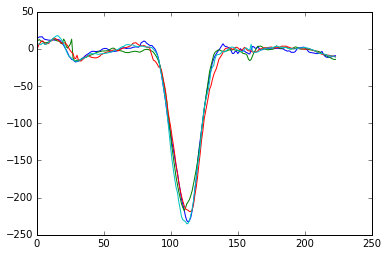

In [24]:
#superdf = pickle.load(open('../dfall_random.pkl'))
#superdf = LoadDataFrame('../data/frame_data/longer_data_frame_aligned.pkl')
#plotComparison(superdf,'Y_Accel',['6','10'],[[(0,'2014-04-04'),(1,'2014-04-04'),(2,'2014-04-04'),(3,'2014-04-04')],[(0,'2014-04-29'),(1,'2014-04-29'),(2,'2014-04-29'),(3,'2014-04-29')]])
#plotUser(superdf,user='6',feature='R_Sig')
plotFeature(superdf,users=['6','10','45','35'],feature='Steer_Angle')